# Decoder架构（gpt架构）

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from typing import Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子以保证可重复性
torch.manual_seed(42)
np.random.seed(42)

# 检查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

使用设备: cuda


## 1. 位置编码（Positional Encoding）

GPT使用可学习的位置嵌入而不是固定的正弦波编码。这里我们实现两种方式供比较。

In [2]:
class PositionalEncoding(nn.Module):
    """正弦波位置编码"""
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        
        # 创建频率分量
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           -(math.log(10000.0) / d_model))
        
        # 正弦波编码：偶数维度使用sin，奇数维度使用cos
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # 注册为buffer，不参与梯度更新
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        return x + self.pe[:, :x.size(1)]


class LearnedPositionalEmbedding(nn.Module):
    """可学习的位置嵌入（GPT使用的方式）"""
    def __init__(self, max_len: int, d_model: int):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        batch_size, seq_len = x.size(0), x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        return x + self.pos_embedding(positions)

## 2. 因果多头注意力机制（Causal Multi-Head Attention）

这是GPT的核心组件，使用因果掩码确保每个位置只能注意到之前的位置。

In [3]:
class CausalMultiHeadAttention(nn.Module):
    """因果多头注意力机制"""
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # 每个头的维度
        
        # 线性投影层
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, seq_len, _ = x.shape
        
        # 1. 线性投影并reshape为多头
        # [batch_size, seq_len, d_model] -> [batch_size, n_heads, seq_len, d_k]
        Q = self.w_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # 2. 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 3. 应用因果掩码（关键！）
        if mask is None:
            # 创建上三角掩码，确保位置i只能看到位置<=i的信息
            mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
            mask = mask.to(x.device)
        scores = scores.masked_fill(mask.unsqueeze(0).unsqueeze(0), float('-inf'))
        
        # 4. Softmax获取注意力权重
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # 5. 应用注意力权重到值向量
        context = torch.matmul(attn_weights, V)
        
        # 6. 重组多头输出
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        # 7. 最终线性投影
        output = self.w_o(context)
        
        return output, attn_weights


def create_causal_mask(seq_len: int) -> torch.Tensor:
    """创建因果注意力掩码"""
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    return mask

# 测试因果掩码
seq_len = 5
mask = create_causal_mask(seq_len)
print("因果掩码（True表示被掩盖）:")
print(mask.int())

因果掩码（True表示被掩盖）:
tensor([[0, 1, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]], dtype=torch.int32)


## 3. 前馈神经网络（Feed-Forward Network）

In [4]:
class FeedForward(nn.Module):
    """位置级前馈网络"""
    def __init__(self, d_model: int, d_ff: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()  # GPT-2使用GELU激活函数
        
    def forward(self, x):
        # 两层线性变换，中间使用GELU激活
        return self.linear2(self.dropout(self.activation(self.linear1(x))))

## 4. Transformer Decoder Block

In [5]:
class TransformerDecoderBlock(nn.Module):
    """单个Transformer Decoder块"""
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        # 自注意力层
        self.self_attn = CausalMultiHeadAttention(d_model, n_heads, dropout)
        # 前馈网络
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        # Layer Normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None):
        # 1. 自注意力子层（带残差连接和Layer Norm）
        # Pre-LN架构：先归一化再计算
        attn_output, attn_weights = self.self_attn(self.norm1(x), mask)
        x = x + self.dropout(attn_output)
        
        # 2. 前馈子层（带残差连接和Layer Norm）
        ff_output = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ff_output)
        
        return x, attn_weights

## 5. 完整的GPT模型架构

In [6]:
class GPTModel(nn.Module):
    """完整的GPT模型"""
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 512,
        n_heads: int = 8,
        n_layers: int = 6,
        d_ff: int = 2048,
        max_len: int = 512,
        dropout: float = 0.1
    ):
        super().__init__()
        
        # 词嵌入层
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        # 位置嵌入（使用可学习的位置嵌入）
        self.position_embedding = LearnedPositionalEmbedding(max_len, d_model)
        
        # 堆叠多个Decoder块
        self.decoder_blocks = nn.ModuleList([
            TransformerDecoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        # 最终的Layer Norm
        self.ln_final = nn.LayerNorm(d_model)
        
        # 输出投影层（将d_model维度映射回vocab_size）
        self.output_projection = nn.Linear(d_model, vocab_size)
        
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
        
        # 初始化参数
        self._init_parameters()
        
    def _init_parameters(self):
        """参数初始化"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def forward(self, input_ids: torch.Tensor, return_attn_weights: bool = False):
        seq_len = input_ids.size(1)
        
        # 1. 词嵌入 + 位置嵌入
        x = self.token_embedding(input_ids) * math.sqrt(self.d_model)  # 缩放
        x = self.position_embedding(x)
        x = self.dropout(x)
        
        # 2. 创建因果掩码
        causal_mask = create_causal_mask(seq_len).to(input_ids.device)
        
        # 3. 通过所有Decoder块
        attn_weights_list = []
        for decoder_block in self.decoder_blocks:
            x, attn_weights = decoder_block(x, causal_mask)
            if return_attn_weights:
                attn_weights_list.append(attn_weights)
        
        # 4. 最终的Layer Norm
        x = self.ln_final(x)
        
        # 5. 投影到词汇表大小
        logits = self.output_projection(x)
        
        if return_attn_weights:
            return logits, attn_weights_list
        return logits
    
    def generate(
        self,
        input_ids: torch.Tensor,
        max_length: int = 50,
        temperature: float = 1.0,
        top_k: Optional[int] = None,
        top_p: Optional[float] = None
    ):
        """文本生成函数"""
        self.eval()
        generated = input_ids
        
        with torch.no_grad():
            for _ in range(max_length - input_ids.size(1)):
                # 前向传播
                logits = self.forward(generated)
                # 只取最后一个位置的logits
                next_token_logits = logits[:, -1, :] / temperature
                
                # 应用top-k采样
                if top_k is not None:
                    indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                    next_token_logits[indices_to_remove] = float('-inf')
                
                # 应用top-p (nucleus) 采样
                if top_p is not None:
                    sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                    
                    # 移除累积概率超过top_p的tokens
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                    sorted_indices_to_remove[..., 0] = 0
                    
                    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                    next_token_logits[indices_to_remove] = float('-inf')
                
                # 采样下一个token
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
                # 添加到生成序列
                generated = torch.cat([generated, next_token], dim=1)
                
                # 如果生成了结束符，停止生成
                if next_token.item() == 0:  # 假设0是结束符
                    break
                    
        return generated

# 创建一个小模型用于演示
model_config = {
    'vocab_size': 100,  # 小词汇表
    'd_model': 128,     # 模型维度
    'n_heads': 4,       # 注意力头数
    'n_layers': 2,      # 层数
    'd_ff': 512,        # FFN维度
    'max_len': 50,      # 最大序列长度
    'dropout': 0.1
}

model = GPTModel(**model_config).to(device)
print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")

模型参数量: 428,900


## 6. 数据准备和Tokenization

使用简单的字符级tokenization和生成式儿童故事作为训练数据。

In [7]:
class SimpleTokenizer:
    """简单的字符级tokenizer"""
    def __init__(self):
        self.char_to_id = {}
        self.id_to_char = {}
        self.vocab_size = 0
        
    def fit(self, texts):
        """基于文本构建词汇表"""
        chars = set(''.join(texts))
        # 添加特殊tokens
        chars = ['<PAD>', '<BOS>', '<EOS>'] + sorted(list(chars))
        
        self.char_to_id = {char: idx for idx, char in enumerate(chars)}
        self.id_to_char = {idx: char for char, idx in self.char_to_id.items()}
        self.vocab_size = len(chars)
        
    def encode(self, text):
        """将文本编码为ID序列"""
        return [self.char_to_id.get(char, self.char_to_id['<PAD>']) for char in text]
    
    def decode(self, ids):
        """将ID序列解码为文本"""
        return ''.join([self.id_to_char.get(idx, '<PAD>') for idx in ids])
    
    def encode_batch(self, texts, max_len=None):
        """批量编码，添加BOS和EOS，并进行padding"""
        encoded = []
        for text in texts:
            ids = [self.char_to_id['<BOS>']] + self.encode(text) + [self.char_to_id['<EOS>']]
            encoded.append(ids)
        
        # Padding到相同长度
        if max_len is None:
            max_len = max(len(ids) for ids in encoded)
        
        padded = []
        for ids in encoded:
            if len(ids) < max_len:
                ids = ids + [self.char_to_id['<PAD>']] * (max_len - len(ids))
            else:
                ids = ids[:max_len]
            padded.append(ids)
            
        return torch.tensor(padded)


# 准备训练数据 - 简单的重复模式文本
training_texts = [
    "hello world",
    "hello gpt",
    "gpt is great",
    "world is beautiful",
    "machine learning is fun",
    "deep learning with gpt",
    "transformer models work well",
    "attention is all you need",
    "the cat sat on mat",
    "the dog ran fast",
    "birds fly high sky",
    "sun shines bright today",
    "moon lights up night",
    "stars twinkle above us",
    "rain falls from clouds",
    "wind blows through trees"
]

# 创建tokenizer
tokenizer = SimpleTokenizer()
tokenizer.fit(training_texts)
print(f"词汇表大小: {tokenizer.vocab_size}")
print(f"词汇表前20个字符: {list(tokenizer.char_to_id.keys())[:20]}")
# 测试编码和解码
test_text = "hello gpt"
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)
print(f"\n原文: {test_text}")
print(f"编码: {encoded}")
print(f"解码: {decoded}")

词汇表大小: 26
词汇表前20个字符: ['<PAD>', '<BOS>', '<EOS>', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r']

原文: hello gpt
编码: [11, 8, 14, 14, 17, 3, 10, 18, 21]
解码: hello gpt


In [8]:
# 准备数据集和数据加载器
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    """简单的文本数据集"""
    def __init__(self, texts, tokenizer, max_len=30):
        self.tokenizer = tokenizer
        self.max_len = max_len
        # 编码所有文本
        self.data = tokenizer.encode_batch(texts, max_len)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 输入是除最后一个token外的所有token
        # 目标是除第一个token外的所有token（向左移位）
        sequence = self.data[idx]
        input_seq = sequence[:-1]
        target_seq = sequence[1:]
        return input_seq, target_seq

# 创建数据集和加载器
dataset = TextDataset(training_texts, tokenizer, max_len=30)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 查看一个批次的数据
for batch_input, batch_target in dataloader:
    print(f"输入形状: {batch_input.shape}")
    print(f"目标形状: {batch_target.shape}")
    print(f"\n第一个样本:")
    print(f"输入: {tokenizer.decode(batch_input[0].tolist())}")
    print(f"目标: {tokenizer.decode(batch_target[0].tolist())}")
    break

输入形状: torch.Size([4, 29])
目标形状: torch.Size([4, 29])

第一个样本:
输入: <BOS>sun shines bright today<EOS><PAD><PAD><PAD><PAD>
目标: sun shines bright today<EOS><PAD><PAD><PAD><PAD><PAD>


## 7. 训练循环

实现标准的GPT训练循环，使用teacher forcing和交叉熵损失。

In [9]:
# 重新创建模型（使用正确的词汇表大小）
model = GPTModel(
    vocab_size=tokenizer.vocab_size,
    d_model=128,
    n_heads=4,
    n_layers=2,
    d_ff=512,
    max_len=50,
    dropout=0.1
).to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.char_to_id['<PAD>'])

def train_epoch(model, dataloader, optimizer, criterion, device):
    """训练一个epoch"""
    model.train()
    total_loss = 0
    
    for batch_input, batch_target in dataloader:
        batch_input = batch_input.to(device)
        batch_target = batch_target.to(device)
        
        # 前向传播
        logits = model(batch_input)
        
        # 计算损失（需要reshape）
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),  # [batch_size * seq_len, vocab_size]
            batch_target.reshape(-1)  # [batch_size * seq_len]
        )
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪（防止梯度爆炸）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# 训练模型
num_epochs = 50
losses = []

print("开始训练...")
for epoch in range(num_epochs):
    loss = train_epoch(model, dataloader, optimizer, criterion, device)
    losses.append(loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

print("训练完成！")

开始训练...
Epoch 10/50, Loss: 1.3434
Epoch 20/50, Loss: 0.6521
Epoch 30/50, Loss: 0.3972
Epoch 40/50, Loss: 0.3640
Epoch 50/50, Loss: 0.3399
训练完成！


/home/haoyiwen/miniconda3/envs/hflearning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/haoyiwen/miniconda3/envs/hflearning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/haoyiwen/miniconda3/envs/hflearning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/haoyiwen/miniconda3/envs/hflearning/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/haoyiwen/miniconda3/envs/hflearning/lib/python

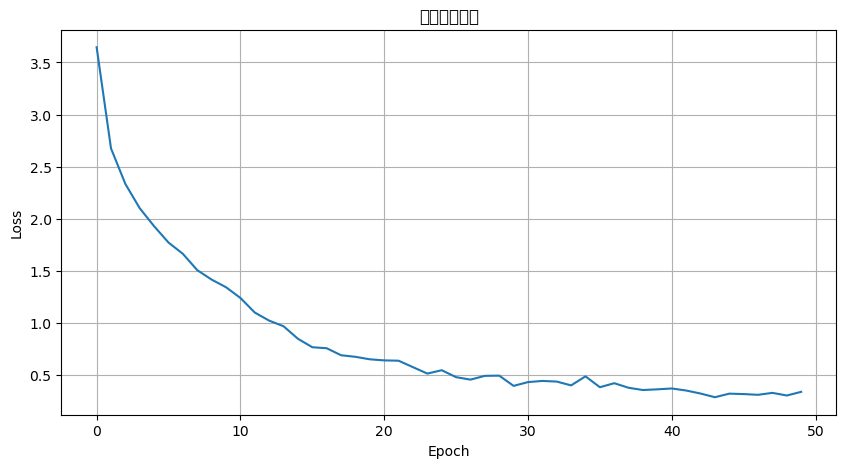

In [10]:
# 绘制训练损失曲线
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('训练损失曲线')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

## 8. 文本生成

使用训练好的模型生成文本，展示不同采样策略的效果。

In [11]:
def generate_text(model, tokenizer, prompt, max_length=50, temperature=1.0, top_k=None, top_p=None):
    """生成文本的辅助函数"""
    model.eval()
    
    # 编码输入提示
    input_ids = [tokenizer.char_to_id['<BOS>']] + tokenizer.encode(prompt)
    input_tensor = torch.tensor([input_ids]).to(device)
    
    # 生成
    with torch.no_grad():
        for _ in range(max_length - len(input_ids)):
            # 前向传播
            logits = model(input_tensor)
            
            # 获取最后一个位置的logits
            next_token_logits = logits[0, -1, :] / temperature
            
            # Top-k采样
            if top_k is not None:
                indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][-1]
                next_token_logits[indices_to_remove] = float('-inf')
            
            # Top-p采样
            if top_p is not None:
                sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
                sorted_indices_to_remove[0] = 0
                
                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                next_token_logits[indices_to_remove] = float('-inf')
            
            # 采样
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            # 检查是否生成了结束符
            if next_token.item() == tokenizer.char_to_id['<EOS>']:
                break
            
            # 添加到序列
            input_tensor = torch.cat([input_tensor, next_token.unsqueeze(0)], dim=1)
    
    # 解码生成的文本
    generated_ids = input_tensor[0].cpu().tolist()
    # 移除BOS和EOS标记
    generated_ids = [id for id in generated_ids if id not in [tokenizer.char_to_id['<BOS>'], tokenizer.char_to_id['<EOS>']]]
    generated_text = tokenizer.decode(generated_ids)
    
    return generated_text

# 测试不同的生成策略
print("="*50)
print("文本生成示例")
print("="*50)

prompts = ["hello", "the", "sun", "world"]

for prompt in prompts:
    print(f"\n提示词: '{prompt}'")
    print("-"*30)
    
    # 贪婪解码（temperature=0.1，接近确定性）
    text = generate_text(model, tokenizer, prompt, max_length=30, temperature=0.1)
    print(f"贪婪解码: {text}")
    
    # 标准采样
    text = generate_text(model, tokenizer, prompt, max_length=30, temperature=0.8)
    print(f"标准采样: {text}")
    
    # Top-k采样
    text = generate_text(model, tokenizer, prompt, max_length=30, temperature=0.8, top_k=5)
    print(f"Top-k采样: {text}")
    
    # Top-p采样
    text = generate_text(model, tokenizer, prompt, max_length=30, temperature=0.8, top_p=0.9)
    print(f"Top-p采样: {text}")

文本生成示例

提示词: 'hello'
------------------------------
贪婪解码: hello world
标准采样: hello world
Top-k采样: hello gpt
Top-p采样: hello world

提示词: 'the'
------------------------------
贪婪解码: the dog ran fast
标准采样: the dog ran fast
Top-k采样: the dog ran fast
Top-p采样: the dog ran fast

提示词: 'sun'
------------------------------
贪婪解码: sun shines brightoday
标准采样: sun shines bright t today
Top-k采样: sun shines brightoday
Top-p采样: sun shines bright today

提示词: 'world'
------------------------------
贪婪解码: world is beautiful
标准采样: world is beautifutifutiful
Top-k采样: world is beautifutiful
Top-p采样: world is beautifutiful


## 9. 注意力权重可视化

可视化因果注意力机制，展示模型如何关注之前的token。

输入文本: 'hello gpt'

注意力权重热力图：


/home/haoyiwen/miniconda3/envs/hflearning/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 27880 (\N{CJK UNIFIED IDEOGRAPH-6CE8}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/haoyiwen/miniconda3/envs/hflearning/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 24847 (\N{CJK UNIFIED IDEOGRAPH-610F}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/haoyiwen/miniconda3/envs/hflearning/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/haoyiwen/miniconda3/envs/hflearning/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 26435 (\N{CJK UNIFIED IDEOGRAPH-6743}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/haoyiwen/miniconda3/envs/hflearning/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.


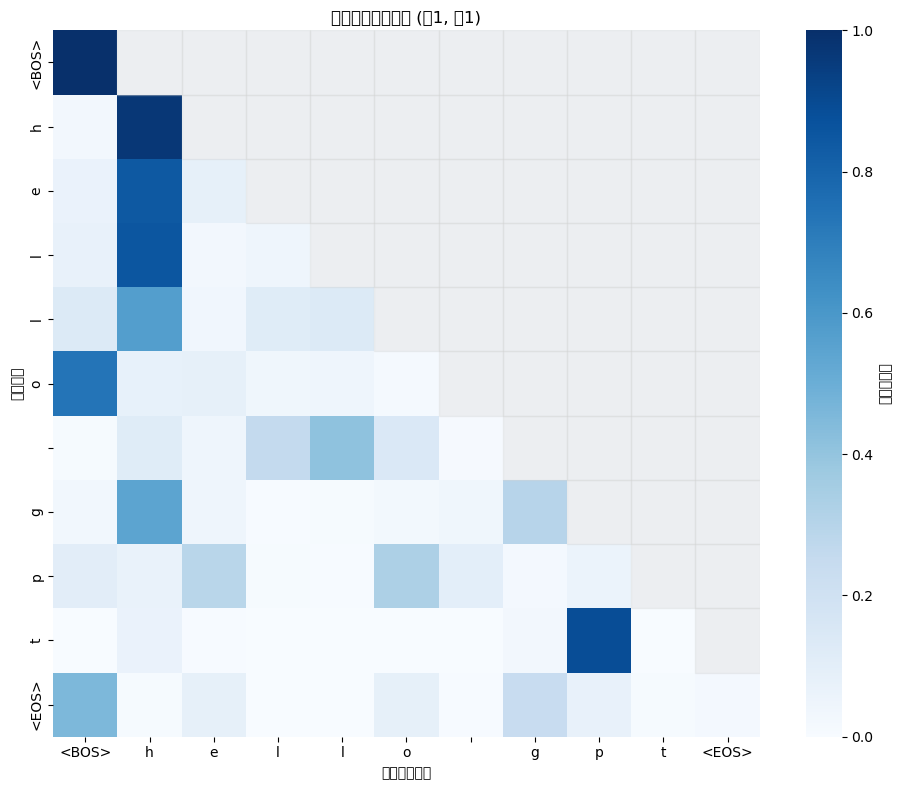

In [12]:
def visualize_attention(model, tokenizer, text, layer_idx=0, head_idx=0):
    """可视化注意力权重"""
    model.eval()
    
    # 编码文本
    input_ids = [tokenizer.char_to_id['<BOS>']] + tokenizer.encode(text) + [tokenizer.char_to_id['<EOS>']]
    input_tensor = torch.tensor([input_ids]).to(device)
    
    # 获取注意力权重
    with torch.no_grad():
        logits, attn_weights_list = model(input_tensor, return_attn_weights=True)
    
    # 获取指定层和头的注意力权重
    attn_weights = attn_weights_list[layer_idx][0, head_idx].cpu().numpy()
    
    # 获取token列表用于显示
    tokens = ['<BOS>'] + list(text) + ['<EOS>']
    
    # 可视化
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn_weights[:len(tokens), :len(tokens)], 
                xticklabels=tokens, 
                yticklabels=tokens,
                cmap='Blues',
                cbar_kws={'label': '注意力权重'},
                square=True,
                vmin=0,
                vmax=1)
    plt.title(f'注意力权重可视化 (层{layer_idx+1}, 头{head_idx+1})')
    plt.xlabel('被注意的位置')
    plt.ylabel('当前位置')
    
    # 添加因果掩码边界线（可选）
    for i in range(len(tokens)):
        for j in range(i+1, len(tokens)):
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='lightgray', alpha=0.3))
    
    plt.tight_layout()
    plt.show()

# 测试注意力可视化
test_text = "hello gpt"
print(f"输入文本: '{test_text}'")
print("\n注意力权重热力图：")
visualize_attention(model, tokenizer, test_text, layer_idx=0, head_idx=0)

因果掩码演示

每个位置可以看到的token：
------------------------------
位置 0 ('The'): 可以看到 ['The']
位置 1 ('cat'): 可以看到 ['The', 'cat']
位置 2 ('sat'): 可以看到 ['The', 'cat', 'sat']
位置 3 ('on'): 可以看到 ['The', 'cat', 'sat', 'on']
位置 4 ('the'): 可以看到 ['The', 'cat', 'sat', 'on', 'the']
位置 5 ('mat'): 可以看到 ['The', 'cat', 'sat', 'on', 'the', 'mat']

掩码矩阵（0=可见，1=被掩盖）：
[[0 1 1 1 1 1]
 [0 0 1 1 1 1]
 [0 0 0 1 1 1]
 [0 0 0 0 1 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]


/tmp/ipykernel_59772/4010504307.py:35: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59772/4010504307.py:35: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59772/4010504307.py:35: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59772/4010504307.py:35: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59772/4010504307.py:35: UserWarning: Glyph 28304 (\N{CJK UNIFIED IDEOGRAPH-6E90}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59772/4010504307.py:35: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_59772/4010504307.py:35: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAP

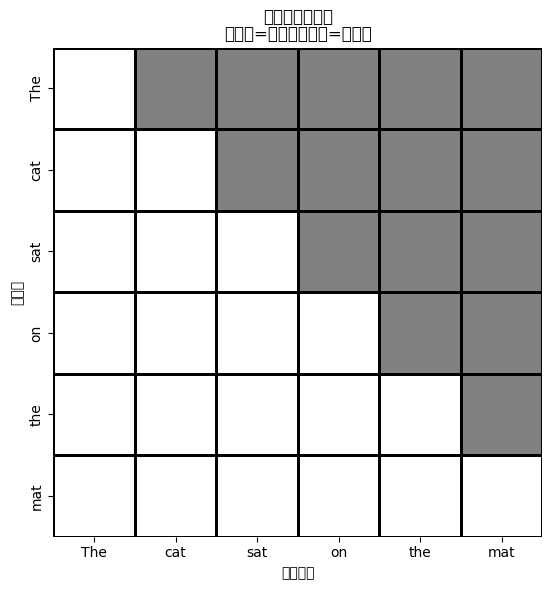

In [13]:
# 演示因果掩码的作用
def demonstrate_causal_mask():
    """演示因果掩码如何防止"看到未来\""""
    seq_len = 6
    tokens = ['The', 'cat', 'sat', 'on', 'the', 'mat']
    
    # 创建因果掩码
    mask = create_causal_mask(seq_len)
    
    print("因果掩码演示")
    print("="*50)
    print("\n每个位置可以看到的token：")
    print("-"*30)
    
    for i in range(seq_len):
        visible = [tokens[j] for j in range(seq_len) if not mask[i, j]]
        print(f"位置 {i} ('{tokens[i]}'): 可以看到 {visible}")
    
    print("\n掩码矩阵（0=可见，1=被掩盖）：")
    print(mask.int().numpy())
    
    # 可视化
    plt.figure(figsize=(8, 6))
    sns.heatmap(mask.int().numpy(), 
                xticklabels=tokens,
                yticklabels=tokens,
                cmap=['white', 'gray'],
                cbar=False,
                square=True,
                linewidths=1,
                linecolor='black')
    plt.title('因果注意力掩码\n（灰色=被掩盖，白色=可见）')
    plt.xlabel('目标位置')
    plt.ylabel('源位置')
    plt.tight_layout()
    plt.show()

demonstrate_causal_mask()

## 10. GPT核心思想总结

### 架构特点
1. **纯Decoder架构**：只使用Transformer的Decoder部分，没有Encoder
2. **因果注意力**：通过上三角掩码确保位置i只能看到位置≤i的信息
3. **自回归生成**：逐个token生成，每次基于之前的所有token预测下一个

### 训练策略
1. **Teacher Forcing**：训练时一次性输入整个序列，通过掩码防止信息泄露
2. **下一个Token预测**：优化目标是预测序列中每个位置的下一个token
3. **并行训练**：虽然生成是串行的，但训练可以并行计算所有位置的损失

### 关键创新
1. **预训练-微调范式**：先在大规模无标注文本上预训练，再针对特定任务微调
2. **上下文学习**：通过输入提示（prompt）引导模型完成各种任务
3. **规模化定律**：模型性能随参数量、数据量和计算量的增加而提升

### 实际应用
- **文本生成**：故事创作、代码生成、对话系统
- **文本理解**：问答、摘要、翻译
- **Few-shot学习**：通过少量示例完成新任务

这个简单的实现展示了GPT的核心机制，现代大语言模型（如GPT-3/4）基于相同原理，但规模更大、训练更充分。